# <p align="center">Depression detection in Sinhala-English code-mixed text</p>
------------

## Importing necessary packages

In [63]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset and Pre-processing

In [64]:
#Importing the dataset
data = pd.read_csv('Singlish_data_New.csv')
data.head()

,text,label
0,nati bari kam aga higa kam mada jeewath wenawa...,1
1,oba samata suba dawasak wewa,0
2,hamadema athaharala giyanam hari wage,1
3,raata dilisena luminious paata tharu tikak kaa...,0
4,mata manasika gataluwak thiyenawa. katha krnna...,1


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1166 non-null   object
 1   label   1166 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.3+ KB


Getting the stop words list from the text file

In [66]:
#merging the custom stop words list and english stop words list
NLTK_stop_words_list=stopwords.words('english')

with open("stop_words.txt") as f:
    content_list = f.readlines()

stop_words = [x.strip() for x in content_list]
final_stop_words = NLTK_stop_words_list + stop_words
print(final_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [67]:
#creating a function to pre-process the Singlish text
def data_processing(text):

    # removal of capitalization
    text = text.lower()
    # remove numbers
    text = re.sub(r"\d+", "", str(text))
    # remove url
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # remove emojis
    text = emoji.replace_emoji(text, replace='')
    # remove re-tweets status
    text = re.sub(r'^RT @\w*: ', ' ', text)
    # remove mentions
    text = re.sub(r'@\w*', ' ', text)
    # remove special characters
    text = re.sub(r'[!@#&*$.?,]', ' ', text)
    # remove \n
    text = re.sub(r'\n', ' ', text)
    # remove ''
    text = re.sub("'", '', text)
    
    
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in final_stop_words]
    preprocessed_text = " ".join(filtered_text)
    return preprocessed_text

In [ ]:
# applying pre-processing on the dataset using a custom written function
data.text = data['text'].apply(data_processing)
# removing duplicates
data = data.drop_duplicates('text')

In [71]:
data.head()

,text,label
0,nati bari kam aga higa kam mada jeewath wenawa...,1
1,samata suba dawasak wewa,0
2,hamadema athaharala giyanam hari,1
3,raata dilisena luminious paata tharu tikak kaa...,0
4,manasika gataluwak thiyenawa katha krnna puluw...,1


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 0 to 1165
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1149 non-null   object
 1   label   1149 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.9+ KB


In [46]:
data['label'].value_counts()

0    638
1    511
Name: label, dtype: int64

## Data visualization and analysis

<AxesSubplot: xlabel='label', ylabel='count'>

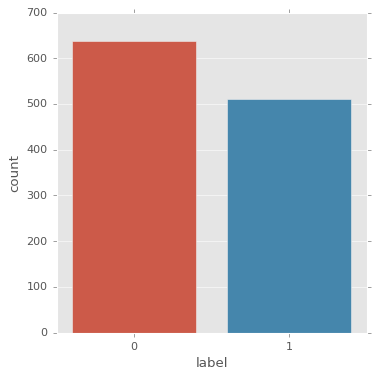

In [47]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = data)

Text(0.5, 1.0, 'Distribution of sentiments')

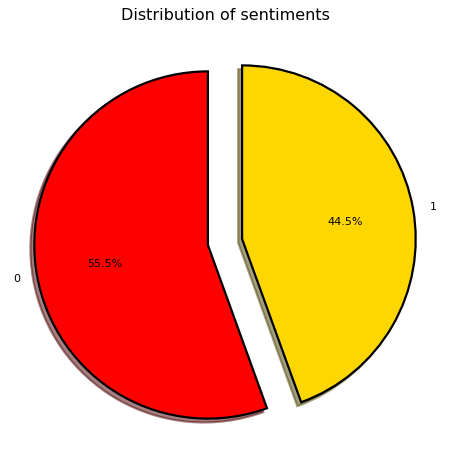

In [48]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = data['label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [49]:
non_depressed = data[data.label == 0]
non_depressed.head()

,text,label
1,samata suba dawasak wewa,0
3,raata dilisena luminious paata tharu tikak kaa...,0
5,mageth thiyenawa maru ne,0
6,ow kochchara hoda karath dakinne na anith aram...,0
7,uthsahaya na nagitinna nagitinna pahalatama wa...,0


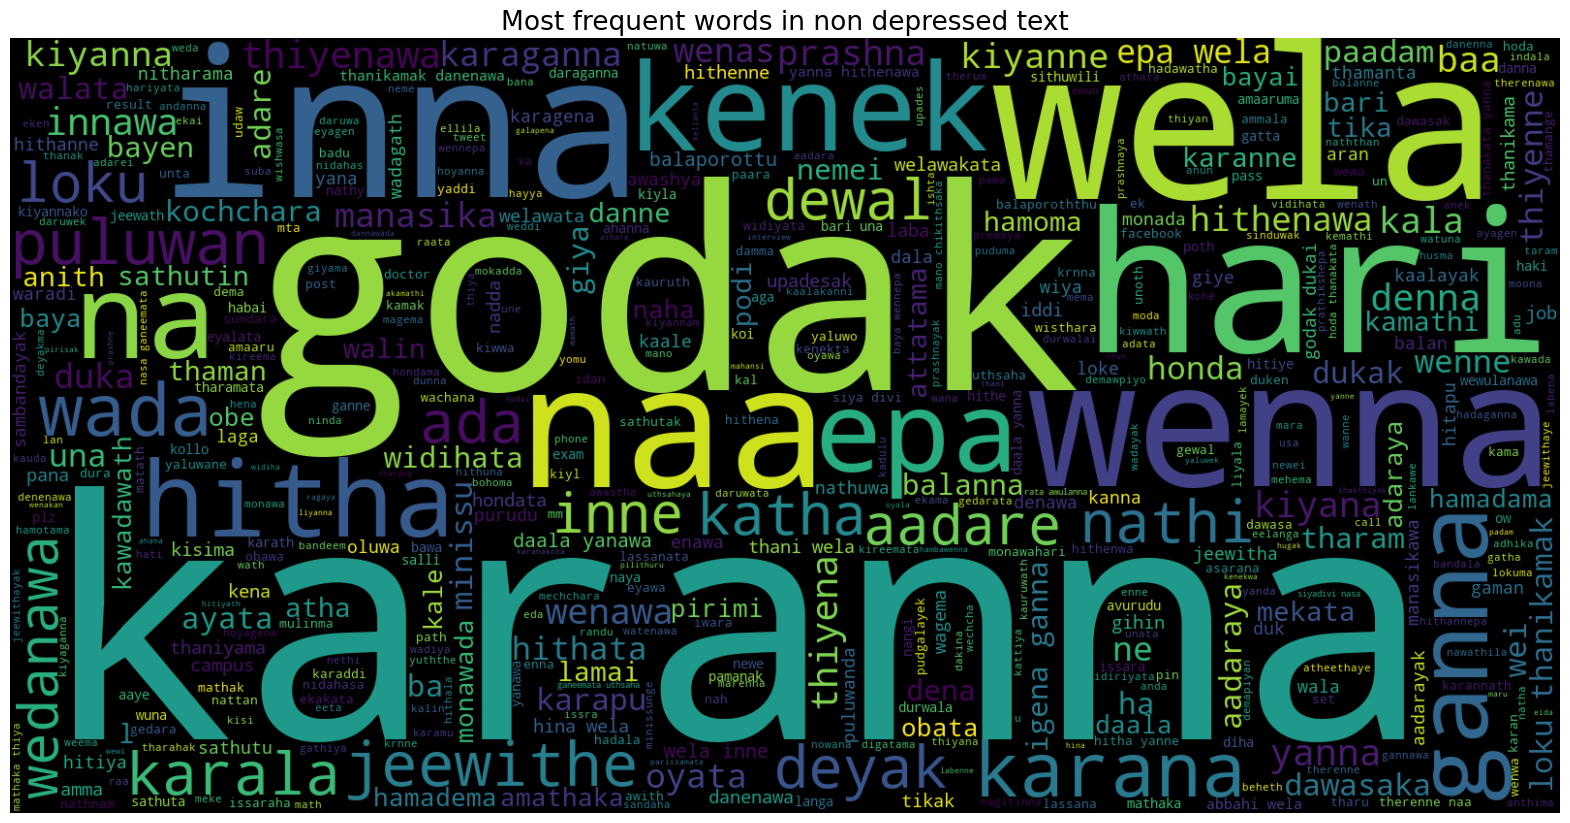

In [15]:
text = ' '.join([word for word in non_depressed['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non depressed text', fontsize = 19)
plt.show()

In [16]:
# extract the words and their frequencies from the WordCloud object
words = wordcloud.words_

# create a list of words from the dictionary
word_list = list(words.keys())

# print the list of words
print(word_list)

# print each word from the list
for word in word_list:
    print(word)

['karanna', 'godak', 'wela', 'inna', 'hari', 'wenna', 'naa', 'kenek', 'na', 'epa', 'hitha', 'ganna', 'karana', 'wada', 'puluwan', 'jeewithe', 'karala', 'nathi', 'ada', 'deyak', 'katha', 'dewal', 'inne', 'aadare', 'loku', 'wedanawa', 'thiyenawa', 'innawa', 'thiyena', 'yanna', 'denna', 'kala', 'baa', 'wenawa', 'kiyana', 'prashna', 'kiyanne', 'kiyanna', 'ne', 'wenas', 'hithenawa', 'karaganna', 'manasika', 'oyata', 'duka', 'epa wela', 'wenne', 'hithata', 'una', 'thiyenne', 'honda', 'wei', 'minissu', 'karapu', 'dawasaka', 'paadam', 'dukak', 'ayata', 'ba', 'adare', 'walata', 'ha', 'aadaraya', 'loku thanikamak', 'kochchara', 'widihata', 'giya', 'bayen', 'balanna', 'nemei', 'dena', 'tharam', 'igena ganna', 'anith', 'lamai', 'danne', 'bari', 'sathutin', 'hamoma', 'karanne', 'kamathi', 'thaman', 'atha', 'podi', 'mekata', 'walin', 'tika', 'attatama', 'l', 'naha', 'kawadawath', 'amathaka', 'hamadama', 'obata', 'baya', 'kale', 'bayai', 'hamadema', 'pirimi', 'adaraya', 'monawada', 'obe', 'daala', 'b

In [50]:
depressed = data[data.label == 1]
depressed.head()

,text,label
0,nati bari kam aga higa kam mada jeewath wenawa...,1
2,hamadema athaharala giyanam hari,1
4,manasika gataluwak thiyenawa katha krnna puluw...,1
8,hamawelema kawruth naha thani wela hithenawa,1
10,hamotama witharak waradhikaraya wenawa hamadam...,1


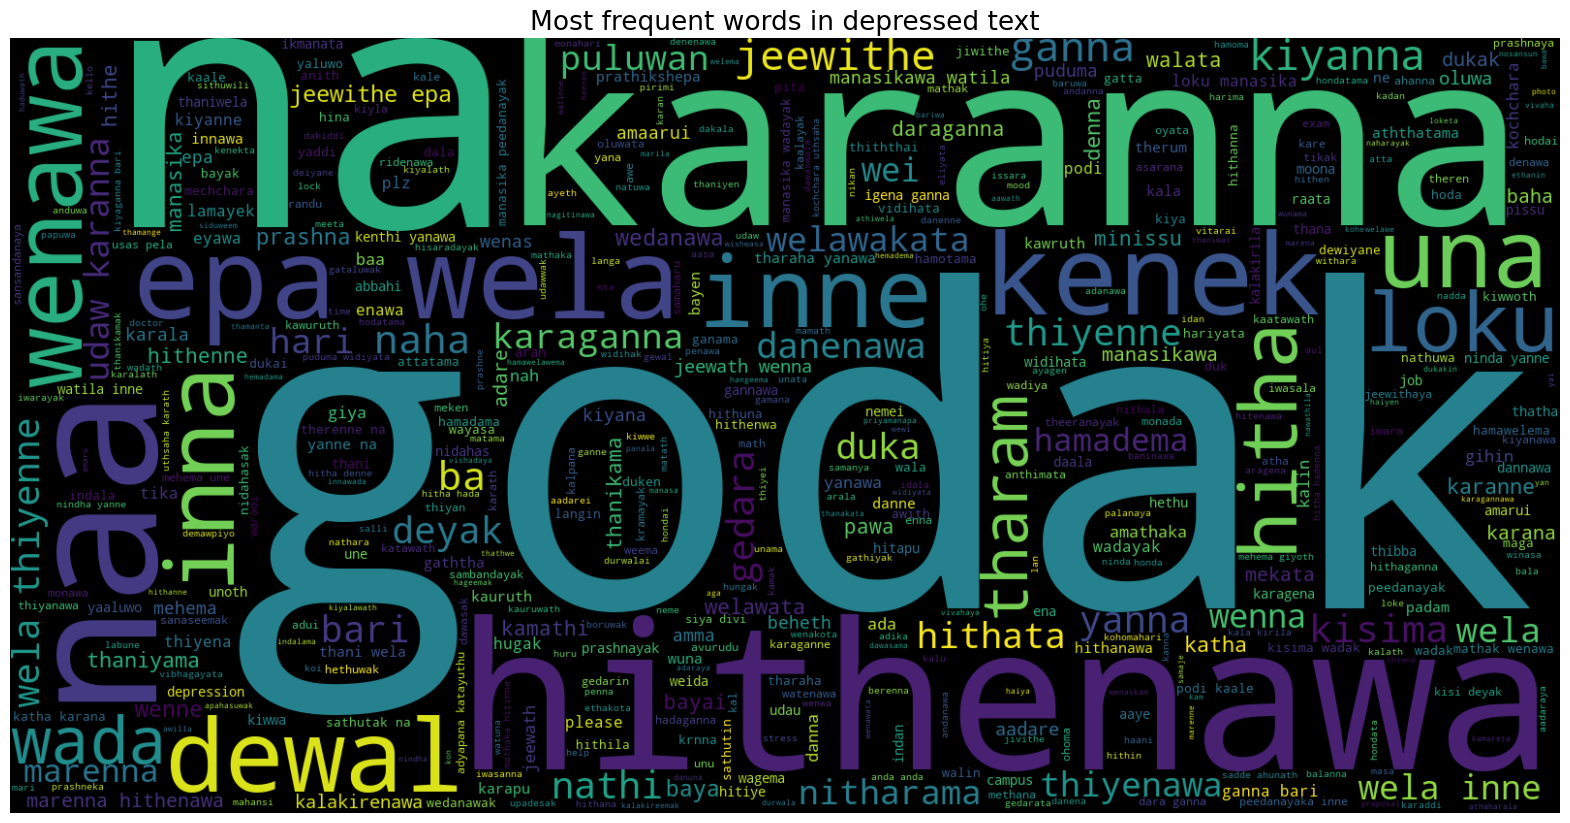

In [17]:
text = ' '.join([word for word in depressed['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in depressed text', fontsize = 19)
plt.show()

In [19]:
# extract the words and their frequencies from the WordCloud object
words = wordcloud.words_

# create a list of words from the dictionary
word_list = list(words.keys())

# print the list of words
print(word_list)

# print each word from the list
for word in word_list:
    print(word)

['godak', 'na', 'karanna', 'hithenawa', 'naa', 'epa wela', 'kenek', 'dewal', 'inne', 'wenawa', 'una', 'inna', 'loku', 'hitha', 'wada', 'tharam', 'kiyanna', 'ganna', 'jeewithe', 'naha', 'ba', 'kisima', 'gedara', 'nathi', 'bari', 'yanna', 'thiyenne', 'deyak', 'wela thiyenne', 'duka', 'hithata', 'danenawa', 'hari', 'puluwan', 'wela', 'karaganna', 'thiyenawa', 'welawakata', 'nitharama', 'udaw karanna', 'wela inne', 'wenna', 'wei', 'hamadema', 'marenna', 'jeewithe epa', 'prashna', 'baya', 'wenne', 'wedanawa', 'katha', 'thaniyama', 'karanne', 'welawata', 'denna', 'manasika', 'kamathi', 'minissu', 'walata', 'thanikama', 'hithenne', 'hithe', 'daraganna', 'bayai', 'pawa', 'dukak', 'manasikawa', 'karana', 'adare', 'mekata', 'baha', 'marenna hithenawa', 'oluwa', 'kalakirenawa', 'aadare', 'jeewath wenna', 'kiyana', 'epa', 'karala', 'puduma', 'mehema', 'wenas', 'beheth', 'amma', 'amaarui', 'manasikawa watila', 'jeewath', 'yanawa', 'gihin', 'kalin', 'giya', 'baa', 'amathaka', 'danna', 'ada', 'nah', 

## Feature extraction

In [72]:
# initializing the tf-idf vectorizer with selected parameters
vect = TfidfVectorizer(ngram_range = (1,5), min_df = 3, analyzer = 'char_wb').fit(data['text'])

In [73]:
# finding the number of features extracted
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))

Number of features: 8015



## Model Building and Training

In [74]:
# transforming the input data using the vectorizer
X = data['text']
Y = data['label']
X = vect.transform(X)

In [75]:
# splitting the dataset into training and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [76]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (919, 8015)
Size of y_train: (919,)
Size of x_test:  (230, 8015)
Size of y_test:  (230,)


In [77]:
def evaluate_classifier(yTest, predict):
    print(confusion_matrix(yTest, predict))
    print("\n")
    print(classification_report(yTest, predict))
    print("---------------------------------------\n")
    # Compute accuracy
    accuracy = accuracy_score(yTest, predict)
    print("Accuracy:", accuracy)

    # Compute precision
    precision = precision_score(yTest, predict)
    print("Precision:", precision)

    # Compute recall
    recall = recall_score(yTest, predict)
    print("Recall:", recall)

    # Compute F1-score
    f1 = f1_score(yTest, predict)
    print("F1-score:", f1)

In [56]:
logreg = LogisticRegression(max_iter=10, penalty='l2', random_state=8, solver='liblinear')
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
evaluate_classifier(y_test, logreg_predict)

[[118  21]
 [ 38  53]]


              precision    recall  f1-score   support

           0       0.76      0.85      0.80       139
           1       0.72      0.58      0.64        91

    accuracy                           0.74       230
   macro avg       0.74      0.72      0.72       230
weighted avg       0.74      0.74      0.74       230

---------------------------------------

Accuracy: 0.7434782608695653
Precision: 0.7162162162162162
Recall: 0.5824175824175825
F1-score: 0.6424242424242425


In [26]:
print(confusion_matrix(y_test, logreg_predict))
print("\n")
print(classification_report(y_test, logreg_predict))

[[118  21]
 [ 38  53]]


              precision    recall  f1-score   support

           0       0.76      0.85      0.80       139
           1       0.72      0.58      0.64        91

    accuracy                           0.74       230
   macro avg       0.74      0.72      0.72       230
weighted avg       0.74      0.74      0.74       230



In [25]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.72
Best parameters:  {'C': 10, 'solver': 'newton-cg'}


In [26]:
y_pred = grid.predict(x_test)
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

Test accuracy: 73.04%
[[109  33]
 [ 29  59]]


              precision    recall  f1-score   support

           0       0.79      0.77      0.78       142
           1       0.64      0.67      0.66        88

    accuracy                           0.73       230
   macro avg       0.72      0.72      0.72       230
weighted avg       0.73      0.73      0.73       230



In [57]:
svm = SVC(C=1, kernel='rbf', probability=True)
svm.fit(x_train, y_train)
svm_predict = svm.predict(x_test)
svm_acc = accuracy_score(svm_predict, y_test)
evaluate_classifier(y_test, svm_predict)

[[119  20]
 [ 36  55]]


              precision    recall  f1-score   support

           0       0.77      0.86      0.81       139
           1       0.73      0.60      0.66        91

    accuracy                           0.76       230
   macro avg       0.75      0.73      0.74       230
weighted avg       0.75      0.76      0.75       230

---------------------------------------

Accuracy: 0.7565217391304347
Precision: 0.7333333333333333
Recall: 0.6043956043956044
F1-score: 0.6626506024096385


In [133]:
print("Test accuarcy: {:.2f}%".format(svm_acc*100))
print(confusion_matrix(y_test, svm_predict))
print("\n")
print(classification_report(y_test, svm_predict))

Test accuarcy: 68.70%
[[109  30]
 [ 42  49]]


              precision    recall  f1-score   support

           0       0.72      0.78      0.75       139
           1       0.62      0.54      0.58        91

    accuracy                           0.69       230
   macro avg       0.67      0.66      0.66       230
weighted avg       0.68      0.69      0.68       230



In [29]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    # 'degree': [1, 3, 5, 7, 9]
}

grid = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, refit = True, verbose = 2)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Cross validation score: 0.74
Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}


In [30]:
grid_predictions = grid.predict(x_test)
grid_acc = accuracy_score(grid_predictions, y_test)
print("Test accuarcy: {:.2f}%".format(grid_acc*100))
print(confusion_matrix(y_test, grid_predictions))
print("\n")
print(classification_report(y_test, grid_predictions))

Test accuarcy: 74.35%
[[113  29]
 [ 30  58]]


              precision    recall  f1-score   support

           0       0.79      0.80      0.79       142
           1       0.67      0.66      0.66        88

    accuracy                           0.74       230
   macro avg       0.73      0.73      0.73       230
weighted avg       0.74      0.74      0.74       230



In [58]:
mnb = MultinomialNB(alpha=0.9)
mnb.fit(x_train, y_train)
mnb_predict = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_predict, y_test)
evaluate_classifier(y_test, mnb_predict)

[[108  31]
 [ 30  61]]


              precision    recall  f1-score   support

           0       0.78      0.78      0.78       139
           1       0.66      0.67      0.67        91

    accuracy                           0.73       230
   macro avg       0.72      0.72      0.72       230
weighted avg       0.74      0.73      0.74       230

---------------------------------------

Accuracy: 0.7347826086956522
Precision: 0.6630434782608695
Recall: 0.6703296703296703
F1-score: 0.6666666666666666


In [135]:
print("Test accuarcy: {:.2f}%".format(mnb_acc*100))
print(confusion_matrix(y_test, mnb_predict))
print("\n")
print(classification_report(y_test, mnb_predict))

Test accuarcy: 69.13%
[[106  33]
 [ 38  53]]


              precision    recall  f1-score   support

           0       0.74      0.76      0.75       139
           1       0.62      0.58      0.60        91

    accuracy                           0.69       230
   macro avg       0.68      0.67      0.67       230
weighted avg       0.69      0.69      0.69       230



In [78]:
dt = DecisionTreeClassifier(min_samples_split = 9, min_samples_leaf = 5)
dt.fit(x_train, y_train)
dt_predict = dt.predict(x_test)
evaluate_classifier(y_test, dt_predict)

[[88 51]
 [47 44]]


              precision    recall  f1-score   support

           0       0.65      0.63      0.64       139
           1       0.46      0.48      0.47        91

    accuracy                           0.57       230
   macro avg       0.56      0.56      0.56       230
weighted avg       0.58      0.57      0.58       230

---------------------------------------

Accuracy: 0.5739130434782609
Precision: 0.4631578947368421
Recall: 0.4835164835164835
F1-score: 0.4731182795698925


In [88]:
rf = RandomForestClassifier(max_features = 'auto', n_estimators = 200)
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
evaluate_classifier(y_test, rf_predict)

[[114  25]
 [ 37  54]]


              precision    recall  f1-score   support

           0       0.75      0.82      0.79       139
           1       0.68      0.59      0.64        91

    accuracy                           0.73       230
   macro avg       0.72      0.71      0.71       230
weighted avg       0.73      0.73      0.73       230

---------------------------------------

Accuracy: 0.7304347826086957
Precision: 0.6835443037974683
Recall: 0.5934065934065934
F1-score: 0.6352941176470589


In [82]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, n_jobs = -1, refit = True, verbose = 2)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Cross validation score: 0.70
Best parameters:  {'max_features': 'auto', 'n_estimators': 200}


In [61]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
knn_predict = knn.predict(x_test)
evaluate_classifier(y_test, knn_predict)

[[93 46]
 [30 61]]


              precision    recall  f1-score   support

           0       0.76      0.67      0.71       139
           1       0.57      0.67      0.62        91

    accuracy                           0.67       230
   macro avg       0.66      0.67      0.66       230
weighted avg       0.68      0.67      0.67       230

---------------------------------------

Accuracy: 0.6695652173913044
Precision: 0.5700934579439252
Recall: 0.6703296703296703
F1-score: 0.616161616161616


In [89]:
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
sgd.fit(x_train, y_train)
sgd_predict = sgd.predict(x_test)
evaluate_classifier(y_test, sgd_predict)

[[109  30]
 [ 46  45]]


              precision    recall  f1-score   support

           0       0.70      0.78      0.74       139
           1       0.60      0.49      0.54        91

    accuracy                           0.67       230
   macro avg       0.65      0.64      0.64       230
weighted avg       0.66      0.67      0.66       230

---------------------------------------

Accuracy: 0.6695652173913044
Precision: 0.6
Recall: 0.4945054945054945
F1-score: 0.5421686746987951


In [91]:
pac = PassiveAggressiveClassifier(C = 0.01)
pac.fit(x_train, y_train)
pac_predict = pac.predict(x_test)
evaluate_classifier(y_test, pac_predict)

[[103  36]
 [ 29  62]]


              precision    recall  f1-score   support

           0       0.78      0.74      0.76       139
           1       0.63      0.68      0.66        91

    accuracy                           0.72       230
   macro avg       0.71      0.71      0.71       230
weighted avg       0.72      0.72      0.72       230

---------------------------------------

Accuracy: 0.717391304347826
Precision: 0.6326530612244898
Recall: 0.6813186813186813
F1-score: 0.6560846560846562


In [80]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0]
}

grid = GridSearchCV(PassiveAggressiveClassifier(), param_grid, cv = 5, n_jobs = -1, refit = True, verbose = 2)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Cross validation score: 0.71
Best parameters:  {'C': 0.01}


In [92]:
abc = AdaBoostClassifier(learning_rate = 0.9, n_estimators = 100)
abc.fit(x_train, y_train)
abc_predict = abc.predict(x_test)
evaluate_classifier(y_test, abc_predict)

[[99 40]
 [33 58]]


              precision    recall  f1-score   support

           0       0.75      0.71      0.73       139
           1       0.59      0.64      0.61        91

    accuracy                           0.68       230
   macro avg       0.67      0.67      0.67       230
weighted avg       0.69      0.68      0.68       230

---------------------------------------

Accuracy: 0.6826086956521739
Precision: 0.5918367346938775
Recall: 0.6373626373626373
F1-score: 0.6137566137566137


In [93]:
gbc = GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 300)
gbc.fit(x_train, y_train)
gbc_predict = gbc.predict(x_test)
evaluate_classifier(y_test, gbc_predict)

[[109  30]
 [ 39  52]]


              precision    recall  f1-score   support

           0       0.74      0.78      0.76       139
           1       0.63      0.57      0.60        91

    accuracy                           0.70       230
   macro avg       0.69      0.68      0.68       230
weighted avg       0.70      0.70      0.70       230

---------------------------------------

Accuracy: 0.7
Precision: 0.6341463414634146
Recall: 0.5714285714285714
F1-score: 0.6011560693641619


In [81]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],  
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 5, n_jobs = -1, refit = True, verbose = 2)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Cross validation score: 0.68
Best parameters:  {'learning_rate': 0.2, 'n_estimators': 300}


In [149]:
etc = ExtraTreesClassifier(max_features='log2', n_estimators=200)
etc.fit(x_train, y_train)
etc_predict = etc.predict(x_test)
evaluate_classifier(y_test, etc_predict)

Test accuarcy: 74.78%
[[119  20]
 [ 38  53]]


              precision    recall  f1-score   support

           0       0.76      0.86      0.80       139
           1       0.73      0.58      0.65        91

    accuracy                           0.75       230
   macro avg       0.74      0.72      0.73       230
weighted avg       0.75      0.75      0.74       230



In [31]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(ExtraTreesClassifier(), param_grid, cv = 5, n_jobs = -1, refit = True, verbose = 2)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Cross validation score: 0.72
Best parameters:  {'max_features': 'sqrt', 'n_estimators': 1000}


In [32]:
grid_predictions = grid.predict(x_test)
grid_acc = accuracy_score(grid_predictions, y_test)
print("Test accuarcy: {:.2f}%".format(grid_acc*100))
print(confusion_matrix(y_test, grid_predictions))
print("\n")
print(classification_report(y_test, grid_predictions))

Test accuarcy: 73.04%
[[111  28]
 [ 34  57]]


              precision    recall  f1-score   support

           0       0.77      0.80      0.78       139
           1       0.67      0.63      0.65        91

    accuracy                           0.73       230
   macro avg       0.72      0.71      0.71       230
weighted avg       0.73      0.73      0.73       230



In [94]:
#voting classifier
clf1 = MultinomialNB(alpha=0.9)
clf2 = LogisticRegression(max_iter=10, penalty='l2', random_state=8, solver='liblinear')
clf3 = SVC(C=1, kernel='rbf', probability=True)

eclf = VotingClassifier(estimators=[('mnb', clf1), ('lr', clf2), ('svm', clf3)], voting='hard')
eclf.fit(x_train, y_train)
eclf_predict = eclf.predict(x_test)
evaluate_classifier(y_test, eclf_predict)

[[118  21]
 [ 37  54]]


              precision    recall  f1-score   support

           0       0.76      0.85      0.80       139
           1       0.72      0.59      0.65        91

    accuracy                           0.75       230
   macro avg       0.74      0.72      0.73       230
weighted avg       0.74      0.75      0.74       230

---------------------------------------

Accuracy: 0.7478260869565218
Precision: 0.72
Recall: 0.5934065934065934
F1-score: 0.6506024096385543


## Evaluation

In [62]:
loaded_clf = joblib.load('depression_classifier.joblib')
loaded_clf_predict = loaded_clf.predict(x_test)
evaluate_classifier(y_test, loaded_clf_predict)

[[122  17]
 [ 31  60]]


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       139
           1       0.78      0.66      0.71        91

    accuracy                           0.79       230
   macro avg       0.79      0.77      0.77       230
weighted avg       0.79      0.79      0.79       230

---------------------------------------

Accuracy: 0.7913043478260869
Precision: 0.7792207792207793
Recall: 0.6593406593406593
F1-score: 0.7142857142857143


Test accuracy: 79.13%


,precision,recall,f1-score,support
0,0.797386,0.877698,0.835616,139.000000
1,0.779221,0.659341,0.714286,91.000000
accuracy,0.791304,0.791304,0.791304,0.791304
macro avg,0.788303,0.768519,0.774951,230.000000
weighted avg,0.790199,0.791304,0.787612,230.000000


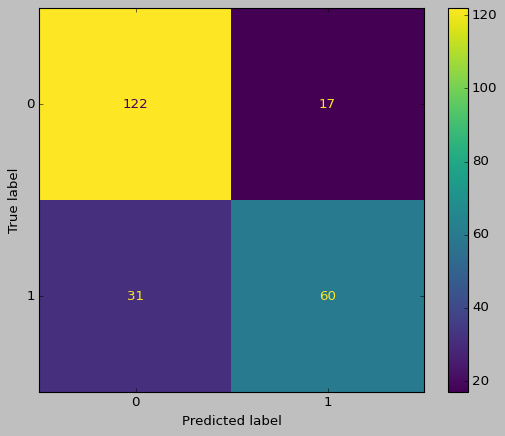

In [31]:
# display test accuracy
eclf_acc = accuracy_score(y_test, loaded_clf_predict)
print("Test accuracy: {:.2f}%".format(eclf_acc*100))

# plot confusion matrix
style.use('classic')
cm = confusion_matrix(y_test, loaded_clf_predict, labels=loaded_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_clf.classes_)
disp.plot()

# display classification report table
report = classification_report(y_test, loaded_clf_predict, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.head()


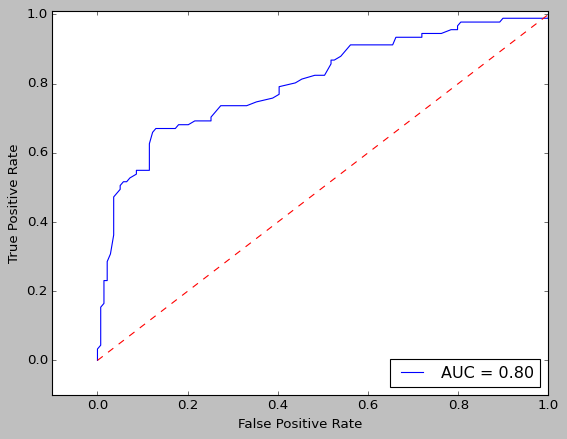

In [26]:
# calculating prediction probability
y_pred_proba = loaded_clf.predict_proba(x_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [63]:
# Save both the vectorizer and the model to disk
filename_clf = 'depression_classifier.joblib'
filename_vectorizer = 'vectorizer.joblib'

joblib.dump(etc, filename_clf)
joblib.dump(vect, filename_vectorizer)

# saving the stop words list
with open("final_stop_words.txt", "w") as f:
    for word in final_stop_words:
        f.write(word + '\n')